In [1]:
import numpy as np
np.set_printoptions(suppress=True)
import time
from numba import njit,guvectorize,float64
import scipy.optimize as opt
from matplotlib import pyplot as plt
import math
#Set
t = np.arange(1, 101)
NT = len(t)

In [2]:
import tensorflow as tf
tf1 = tf.constant("hellow")
sess = tf.Session()
print(sess.run(tf1))

C:\Users\lenovo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\lenovo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\lenovo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\lenovo\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: P

b'hellow'


In [3]:
#Parameters
fosslim = 6000 # Maximum cumulative extraction fossil fuels (GtC); denoted by CCum
tstep  = 5 # Years per Period
ifopt  = 0 # Indicator where optimized is 1 and base is 0

In [4]:
#Preferences

elasmu = 1.45 #  Elasticity of marginal utility of consumption
prstp = 0.015 #   Initial rate of social time preference per year 

#** Population and technology
gama  = 0.300 #   Capital elasticity in production function         /.300 /
pop0  = 7403   # Initial world population 2015 (millions)          /7403 /
popadj = 0.134 #  Growth rate to calibrate to 2050 pop projection  /0.134/
popasym = 11500 # Asymptotic population (millions)                 /11500/
dk  = 0.100 #     Depreciation rate on capital (per year)           /.100 /
q0  = 105.5 #     Initial world gross output 2015 (trill 2010 USD) /105.5/
k0  = 223 #     Initial capital value 2015 (trill 2010 USD)        /223  /
a0  = 5.115 #     Initial level of total factor productivity       /5.115/
ga0  = 0.076 #    Initial growth rate for TFP per 5 years          /0.076/
dela  = 0.005 #   Decline rate of TFP per 5 years                  /0.005/

#** Emissions parameters
gsigma1  = -0.0152 # Initial growth of sigma (per year)            /-0.0152/
dsig  = -0.001 #   Decline rate of decarbonization (per period)    /-0.001 /
eland0 = 2.6 #  Carbon emissions from land 2015 (GtCO2 per year)   / 2.6   /
deland = 0.115 # Decline rate of land emissions (per period)        / .115  /
e0 = 35.85 #    Industrial emissions 2015 (GtCO2 per year)       /35.85  /
miu0  = 0.03 #   Initial emissions control rate for base case 2015  /.03    /

#** Carbon cycle
#* Initial Conditions
mat0 = 851 #  Initial Concentration in atmosphere 2015 (GtC)       /851  /
mu0  = 460 #  Initial Concentration in upper strata 2015 (GtC)     /460  /
ml0  = 1740 #  Initial Concentration in lower strata 2015 (GtC)    /1740 /
mateq = 588 # mateq Equilibrium concentration atmosphere  (GtC)    /588  /
mueq  = 360 # mueq Equilibrium concentration in upper strata (GtC) /360  /
mleq = 1720 # mleq Equilibrium concentration in lower strata (GtC) /1720 /

#* Flow paramaters, denoted by Phi_ij in the model
b12  = 0.12 #    Carbon cycle transition matrix                     /.12  /
b23  = 0.007 #   Carbon cycle transition matrix                    /0.007/
#* These are for declaration and are defined later
b11  = None   # Carbon cycle transition matrix
b21  = None  # Carbon cycle transition matrix
b22  = None  # Carbon cycle transition matrix
b32  = None  # Carbon cycle transition matrix
b33  = None  # Carbon cycle transition matrix
sig0  = None  # Carbon intensity 2010 (kgCO2 per output 2005 USD 2010)

#** Climate model parameters
t2xco2  = 3.1 # Equilibrium temp impact (oC per doubling CO2)    / 3.1 /
fex0  = 0.5 #   2015 forcings of non-CO2 GHG (Wm-2)              / 0.5 /
fex1  = 1.0 #   2100 forcings of non-CO2 GHG (Wm-2)              / 1.0 /
tocean0  = 0.0068 # Initial lower stratum temp change (C from 1900) /.0068/
tatm0  = 0.85 #  Initial atmospheric temp change (C from 1900)    /0.85/
c1  = 0.1005 #     Climate equation coefficient for upper level  /0.1005/
c3  = 0.088 #     Transfer coefficient upper to lower stratum    /0.088/
c4  = 0.025 #     Transfer coefficient for lower level           /0.025/
fco22x  = 3.6813 # eta in the model; Eq.22 : Forcings of equilibrium CO2 doubling (Wm-2)   /3.6813 /

#** Climate damage parameters
a10  = 0 #     Initial damage intercept                         /0   /
a20  = None #     Initial damage quadratic term
a1  = 0 #      Damage intercept                                 /0   /
a2  = 0.00236 #      Damage quadratic term                     /0.00236/
a3  = 2.00 #      Damage exponent                              /2.00   /

#** Abatement cost
expcost2 = 2.6 # Theta2 in the model, Eq. 10 Exponent of control cost function             / 2.6  /
pback  = 550 #   Cost of backstop 2010$ per tCO2 2015          / 550  /
gback  = 0.025 #   Initial cost decline backstop cost per period / .025/
limmiu  = 1.2 #  Upper limit on control rate after 2150        / 1.2 /
tnopol  = 45 #  Period before which no emissions controls base  / 45   /
cprice0  = 2 # Initial base carbon price (2010$ per tCO2)      / 2    /
gcprice  = 0.02 # Growth rate of base carbon price per year     /.02  /

#** Scaling and inessential parameters
#* Note that these are unnecessary for the calculations
#* They ensure that MU of first period's consumption =1 and PV cons = PV utilty
scale1  = 0.0302455265681763 #    Multiplicative scaling coefficient           /0.0302455265681763 /
scale2  = -10993.704 #    Additive scaling coefficient       /-10993.704/;

In [5]:
#* Parameters for long-run consistency of carbon cycle 
#(Question)
b11 = 1 - b12
b21 = b12*mateq/mueq
b22 = 1 - b21 - b23
b32 = b23*mueq/mleq
b33 = 1 - b32

#* Further definitions of parameters
a20 = a2
sig0 = e0/(q0*(1-miu0)) #From Eq. 14
lam = fco22x/ t2xco2 #From Eq. 25

l = np.zeros(NT)
l[0] = pop0 #Labor force
al = np.zeros(NT) 
al[0] = a0
gsig = np.zeros(NT) 
gsig[0] = gsigma1
sigma = np.zeros(NT)
sigma[0]= sig0
ga = ga0 * np.exp(-dela*5*(t-1)) #TFP growth rate dynamics, Eq. 7
pbacktime = pback * (1-gback)**(t-1) #Backstop price
etree = eland0*(1-deland)**(t-1) #Emissions from deforestration
rr = 1/((1+prstp)**(tstep*(t-1))) #Eq. 3
#The following three equations define the exogenous radiative forcing; used in Eq. 23  
forcoth = np.full(NT,fex0)
forcoth[0:18] = forcoth[0:18] + (1/17)*(fex1-fex0)*(t[0:18]-1)
forcoth[18:NT] = forcoth[18:NT] + (fex1-fex0)
optlrsav = (dk + .004)/(dk + .004*elasmu + prstp)*gama #Optimal long-run savings rate used for transversality (Question)
cost1 = np.zeros(NT)
cumetree = np.zeros(NT)
cumetree[0] = 100
cpricebase = cprice0*(1+gcprice)**(5*(t-1)) 

In [6]:
@njit('(float64[:], int32)')
def InitializeLabor(il,iNT):
    for i in range(1,iNT):
        il[i] = il[i-1]*(popasym / il[i-1])**popadj

@njit('(float64[:], int32)')        
def InitializeTFP(ial,iNT):
    for i in range(1,iNT):
        ial[i] = ial[i-1]/(1-ga[i-1])
        
@njit('(float64[:], int32)')        
def InitializeGrowthSigma(igsig,iNT):
    for i in range(1,iNT):
        igsig[i] = igsig[i-1]*((1+dsig)**tstep)
        
@njit('(float64[:], float64[:],float64[:],int32)')        
def InitializeSigma(isigma,igsig,icost1,iNT):
    for i in range(1,iNT):
        isigma[i] =  isigma[i-1] * np.exp(igsig[i-1] * tstep)
        icost1[i] = pbacktime[i] * isigma[i]  / expcost2 /1000
        
@njit('(float64[:], int32)')        
def InitializeCarbonTree(icumetree,iNT):
    for i in range(1,iNT):
        icumetree[i] = icumetree[i-1] + etree[i-1]*(5/3.666)


In [7]:
"""
Functions of the model
"""

"""
First: Functions related to emissions of carbon and weather damages
"""

# Retuns the total carbon emissions; Eq. 18
@njit('float64(float64[:],int32)') 
def fE(iEIND,index):
    return iEIND[index] + etree[index]

#Eq.14: Determines the emission of carbon by industry EIND
@njit('float64(float64[:],float64[:],float64[:],int32)') 
def fEIND(iYGROSS, iMIU, isigma,index):
    return isigma[index] * iYGROSS[index] * (1 - iMIU[index])

#Cumulative industrial emission of carbon
@njit('float64(float64[:],float64[:],int32)') 
def fCCA(iCCA,iEIND,index):
    return iCCA[index-1] + iEIND[index-1] * 5 / 3.666

#Cumulative total carbon emission
@njit('float64(float64[:],float64[:],int32)')
def fCCATOT(iCCA,icumetree,index):
    return iCCA[index] + icumetree[index]

#Eq. 22: the dynamics of the radiative forcing
@njit('float64(float64[:],int32)')
def fFORC(iMAT,index):
    return fco22x * np.log(iMAT[index]/588.000)/np.log(2) + forcoth[index]

# Dynamics of Omega; Eq.9
@njit('float64(float64[:],int32)')
def fDAMFRAC(iTATM,index):
    return a1*iTATM[index] + a2*iTATM[index]**a3

#Calculate damages as a function of Gross industrial production; Eq.8 
@njit('float64(float64[:],float64[:],int32)')
def fDAMAGES(iYGROSS,iDAMFRAC,index):
    return iYGROSS[index] * iDAMFRAC[index]

#Dynamics of Lambda; Eq. 10 - cost of the reudction of carbon emission (Abatement cost)
@njit('float64(float64[:],float64[:],float64[:],int32)') 
def fABATECOST(iYGROSS,iMIU,icost1,index):
    return iYGROSS[index] * icost1[index] * iMIU[index]**expcost2

#Marginal Abatement cost
@njit('float64(float64[:],int32)')
def fMCABATE(iMIU,index):
    return pbacktime[index] * iMIU[index]**(expcost2-1)

#Price of carbon reduction
@njit('float64(float64[:],int32)')
def fCPRICE(iMIU,index):
    return pbacktime[index] * (iMIU[index])**(expcost2-1)

#Eq. 19: Dynamics of the carbon concentration in the atmosphere
@njit('float64(float64[:],float64[:],float64[:],int32)') 
def fMAT(iMAT,iMU,iE,index):
    if(index == 0):
        return mat0
    else:
        return iMAT[index-1]*b11 + iMU[index-1]*b21 + iE[index-1] * 5 / 3.666

#Eq. 21: Dynamics of the carbon concentration in the ocean LOW level
@njit('float64(float64[:],float64[:],int32)') 
def fML(iML,iMU,index):
    if(index == 0):
        return ml0
    else:
        return iML[index-1] * b33  + iMU[index-1] * b23

#Eq. 20: Dynamics of the carbon concentration in the ocean UP level
@njit('float64(float64[:],float64[:],float64[:],int32)') 
def fMU(iMAT,iMU,iML,index):
    if(index == 0):
        return mu0
    else:
        return iMAT[index-1]*b12 + iMU[index-1]*b22 + iML[index-1]*b32

#Eq. 23: Dynamics of the atmospheric temperature
@njit('float64(float64[:],float64[:],float64[:],int32)') 
def fTATM(iTATM,iFORC,iTOCEAN,index):
    if(index == 0):
        return tatm0
    else:
        return iTATM[index-1] + c1 * (iFORC[index] - (fco22x/t2xco2) * iTATM[index-1] - c3 * (iTATM[index-1] - iTOCEAN[index-1]))

#Eq. 24: Dynamics of the ocean temperature
@njit('float64(float64[:],float64[:],int32)')
def fTOCEAN(iTATM,iTOCEAN,index):
    if(index == 0):
        return tocean0
    else:
        return iTOCEAN[index-1] + c4 * (iTATM[index-1] - iTOCEAN[index-1])

"""
Second: Function related to economic variables
"""

#The total production without climate losses denoted previously by YGROSS
@njit('float64(float64[:],float64[:],float64[:],int32)')
def fYGROSS(ial,il,iK,index):
    return ial[index] * ((il[index]/1000)**(1-gama)) * iK[index]**gama

#The production under the climate damages cost
@njit('float64(float64[:],float64[:],int32)')
def fYNET(iYGROSS, iDAMFRAC, index):
    return iYGROSS[index] * (1 - iDAMFRAC[index])

#Production after abatement cost
@njit('float64(float64[:],float64[:],int32)')
def fY(iYNET,iABATECOST,index):
    return iYNET[index] - iABATECOST[index]

#Consumption Eq. 11
@njit('float64(float64[:],float64[:],int32)')
def fC(iY,iI,index):
    return iY[index] - iI[index]

#Per capita consumption, Eq. 12
@njit('float64(float64[:],float64[:],int32)')
def fCPC(iC,il,index):
    return 1000 * iC[index] / il[index]

#Saving policy: investment
@njit('float64(float64[:],float64[:],int32)')
def fI(iS,iY,index):
    return iS[index] * iY[index] 

#Capital dynamics Eq. 13
@njit('float64(float64[:],float64[:],int32)')
def fK(iK,iI,index):
    if(index == 0):
        return k0
    else:
        return (1-dk)**tstep * iK[index-1] + tstep * iI[index-1]

#Interest rate equation; Eq. 26 added in personal notes
@njit('float64(float64[:],int32)')
def fRI(iCPC,index):
    return (1 + prstp) * (iCPC[index+1]/iCPC[index])**(elasmu/tstep) - 1

#Periodic utility: A form of Eq. 2
@njit('float64(float64[:],float64[:],int32)')
def fCEMUTOTPER(iPERIODU,il,index):
    return iPERIODU[index] * il[index] * rr[index]

#The term between brackets in Eq. 2
@njit('float64(float64[:],float64[:],int32)')
def fPERIODU(iC,il,index):
    return ((iC[index]*1000/il[index])**(1-elasmu) - 1) / (1 - elasmu) - 1

#utility function
@guvectorize([(float64[:], float64[:])], '(n), (m)')
def fUTILITY(iCEMUTOTPER, resUtility):
    resUtility[0] = tstep * scale1 * np.sum(iCEMUTOTPER) + scale2


In [8]:

"""
In this part we implement the objective function
"""

# * Control rate limits
MIU_lo = np.full(NT,0.01)
MIU_up = np.full(NT,limmiu)
MIU_up[0:29] = 1
MIU_lo[0] = miu0
MIU_up[0] = miu0
MIU_lo[MIU_lo==MIU_up] = 0.99999*MIU_lo[MIU_lo==MIU_up]
bnds1=[]
for i in range(NT):
    bnds1.append((MIU_lo[i],MIU_up[i]))
# * Control variables
lag10 = t > NT - 10
S_lo = np.full(NT,1e-1)
S_lo[lag10] = optlrsav
S_up = np.full(NT,0.9)
S_up[lag10] = optlrsav
S_lo[S_lo==S_up] = 0.99999*S_lo[S_lo==S_up]
bnds2=[]
for i in range(NT):
    bnds2.append((S_lo[i],S_up[i]))
    
# Arbitrary starting values for the control variables:
S_start = np.full(NT,0.2)
S_start[S_start < S_lo] = S_lo[S_start < S_lo]
S_start[S_start > S_up] = S_lo[S_start > S_up]
MIU_start = 0.99*MIU_up
MIU_start[MIU_start < MIU_lo] = MIU_lo[MIU_start < MIU_lo]
MIU_start[MIU_start > MIU_up] = MIU_up[MIU_start > MIU_up]

K = np.zeros(NT)
YGROSS = np.zeros(NT)
EIND = np.zeros(NT)
E = np.zeros(NT)
CCA = np.zeros(NT)
CCATOT = np.zeros(NT)
MAT = np.zeros(NT)
ML = np.zeros(NT)
MU = np.zeros(NT)
FORC = np.zeros(NT)
TATM = np.zeros(NT)
TOCEAN = np.zeros(NT)
DAMFRAC = np.zeros(NT)
DAMAGES = np.zeros(NT)
ABATECOST = np.zeros(NT)
MCABATE = np.zeros(NT)
CPRICE = np.zeros(NT)
YNET = np.zeros(NT)
Y = np.zeros(NT)
I = np.zeros(NT)
C = np.zeros(NT)
CPC = np.zeros(NT)
RI = np.zeros(NT)
PERIODU = np.zeros(NT)
CEMUTOTPER = np.zeros(NT)

In [9]:
#The objective function
#It returns the utility as scalar
def fOBJ(x,sign,iI,iK,ial,il,iYGROSS,isigma,iEIND,iE,iCCA,iCCATOT,icumetree,iMAT,iMU,iML,iFORC,iTATM,iTOCEAN,iDAMFRAC,iDAMAGES,iABATECOST,icost1,iMCABATE,
         iCPRICE,iYNET,iY,iC,iCPC,iPERIODU,iCEMUTOTPER,iRI,iNT):
    
    iMIU = x[0:iNT]
    iS = x[iNT:(2*iNT)]
    
    for i in range(iNT):
        iK[i] = fK(iK,iI,i)
        iYGROSS[i] = fYGROSS(ial,il,iK,i)
        iEIND[i] = fEIND(iYGROSS, iMIU, isigma,i)
        iE[i] = fE(iEIND,i)
        iCCA[i] = fCCA(iCCA,iEIND,i)
        iCCATOT[i] = fCCATOT(iCCA,icumetree,i)
        iMAT[i] = fMAT(iMAT,iMU,iE,i)
        iML[i] = fML(iML,iMU,i)
        iMU[i] = fMU(iMAT,iMU,iML,i)
        iFORC[i] = fFORC(iMAT,i)
        iTATM[i] = fTATM(iTATM,iFORC,iTOCEAN,i)
        iTOCEAN[i] = fTOCEAN(iTATM,iTOCEAN,i)
        iDAMFRAC[i] = fDAMFRAC(iTATM,i)
        iDAMAGES[i] = fDAMAGES(iYGROSS,iDAMFRAC,i)
        iABATECOST[i] = fABATECOST(iYGROSS,iMIU,icost1,i)
        iMCABATE[i] = fMCABATE(iMIU,i)
        iCPRICE[i] = fCPRICE(iMIU,i)
        iYNET[i] = fYNET(iYGROSS, iDAMFRAC, i)
        iY[i] = fY(iYNET,iABATECOST,i)
        iI[i] = fI(iS,iY,i)
        iC[i] = fC(iY,iI,i)
        iCPC[i] = fCPC(iC,il,i)
        iPERIODU[i] = fPERIODU(iC,il,i)
        iCEMUTOTPER[i] = fCEMUTOTPER(iPERIODU,il,i)
        iRI = fRI(iCPC,i)
        
    resUtility = np.zeros(1)
    fUTILITY(iCEMUTOTPER, resUtility)
    
    return sign*resUtility[0]

In [10]:
InitializeLabor(l,NT)
InitializeTFP(al,NT)
InitializeGrowthSigma(gsig,NT)
InitializeSigma(sigma,gsig,cost1,NT)
InitializeCarbonTree(cumetree,NT)

In [11]:
class DQN:
    def __init__(self, learning_rate, gamma, n_features, n_actions, epsilon, parameter_changing_pointer, memory_size):

        self.learning_rate = learning_rate
        self.gamma = gamma
        self.n_features = n_features
        self.n_actions = n_actions
        self.epsilon = epsilon
        self.batch_size = 100
        self.experience_counter = 0
        self.experience_limit = memory_size
        self.replace_target_pointer = parameter_changing_pointer
        self.learning_counter = 0
        self.memory = np.zeros([self.experience_limit, self.n_features * 2 + 2])

        self.build_networks()
        p_params = tf.get_collection('primary_network_parameters')
        t_params = tf.get_collection('target_network_parameters')
        self.replacing_target_parameters = [tf.assign(t, p) for t, p in zip(t_params, p_params)]

        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def build_networks(self):
        # primary network
        hidden_units = 100
        self.s = tf.placeholder(tf.float32, [None, self.n_features])
        self.qtarget = tf.placeholder(tf.float32, [None, self.n_actions])

        with tf.variable_scope('primary_network'):
            c = ['primary_network_parameters', tf.GraphKeys.GLOBAL_VARIABLES]
            with tf.variable_scope('layer1'):
                w1 = tf.get_variable('w1', [self.n_features, hidden_units],
                                     initializer=tf.contrib.layers.xavier_initializer(),
                                     dtype=tf.float32, collections=c)
                b1 = tf.get_variable('b1', [1, hidden_units], initializer=tf.contrib.layers.xavier_initializer(),
                                     dtype=tf.float32, collections=c)
                l1 = tf.nn.relu(tf.matmul(self.s, w1) + b1)

            with tf.variable_scope('layer2'):
                w2 = tf.get_variable('w2', [hidden_units, self.n_actions],
                                     initializer=tf.contrib.layers.xavier_initializer(),
                                     dtype=tf.float32, collections=c)
                b2 = tf.get_variable('b2', [1, self.n_actions], initializer=tf.contrib.layers.xavier_initializer(),
                                     dtype=tf.float32, collections=c)
                self.qeval = tf.matmul(l1, w2) + b2

        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.squared_difference(self.qtarget, self.qeval))

        with tf.variable_scope('optimiser'):
            self.train = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

        # target network
        self.st = tf.placeholder(tf.float32, [None, self.n_features])

        with tf.variable_scope('target_network'):
            c = ['target_network_parameters', tf.GraphKeys.GLOBAL_VARIABLES]
            with tf.variable_scope('layer1'):
                w1 = tf.get_variable('w1', [self.n_features, hidden_units],
                                     initializer=tf.contrib.layers.xavier_initializer(),
                                     dtype=tf.float32, collections=c)
                b1 = tf.get_variable('b1', [1, hidden_units], initializer=tf.contrib.layers.xavier_initializer(),
                                     dtype=tf.float32, collections=c)
                l1 = tf.nn.relu(tf.matmul(self.st, w1) + b1)

            with tf.variable_scope('layer2'):
                w2 = tf.get_variable('w2', [hidden_units, self.n_actions],
                                     initializer=tf.contrib.layers.xavier_initializer(),
                                     dtype=tf.float32, collections=c)
                b2 = tf.get_variable('b2', [1, self.n_actions], initializer=tf.contrib.layers.xavier_initializer(),
                                     dtype=tf.float32, collections=c)
                self.qt = tf.matmul(l1, w2) + b2
                
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.squared_difference(self.qtarget, self.qeval))
    
    def target_params_replaced(self):
        self.sess.run(self.replacing_target_parameters)
        
    def store_experience(self, obs, a, r, obs_):
        index = self.experience_counter % self.experience_limit
        self.memory[index, :] = np.hstack((obs, [a, r], obs_))
        self.experience_counter += 1
        
    def epsilon_greedy(self, obs):
        if np.random.uniform(low=0, high=1) < self.epsilon:
            return np.argmax(self.sess.run(self.qeval, feed_dict={self.s: obs[np.newaxis, :]}))
        else:
            return np.random.choice(self.n_actions)

    def fit(self):
        if self.experience_counter < self.experience_limit:
            indices = np.random.choice(self.experience_counter, size=self.batch_size)
        else:
            indices = np.random.choice(self.experience_limit, size=self.batch_size)
        
        batch = self.memory[indices, :]
        qt, qeval = self.sess.run([self.qt, self.qeval],
                                  feed_dict={self.st: batch[:, -self.n_features:], self.s: batch[:, :self.n_features]})

        qtarget = qeval.copy()
        batch_indices = np.arange(self.batch_size, dtype=np.int32)
        actions = self.memory[indices, self.n_features].astype(int)
        rewards = self.memory[indices, self.n_features + 1]
        qtarget[batch_indices, actions] = rewards + self.gamma * np.max(qt, axis=1)
        _ = self.sess.run(self.train, feed_dict={self.s: batch[:, :self.n_features], 
                                                 self.qtarget: qtarget})

        if self.epsilon < 0.9:
            self.epsilon += 0.02

        if self.learning_counter % self.replace_target_pointer == 0:
            self.target_params_replaced()

        self.learning_counter += 1

In [12]:
class OPTIM(object):
    def __init__(self):
        super(OPTIM, self).__init__()
        self.n_features = 3
    
    def step(self, action):
        global x, x1, x2, RE, REX
        
        miu = (math.floor(action/100)+1)/101*(MIU_up[steps]-MIU_lo[steps])+MIU_lo[steps]
        s = (action%100+1)/101*(S_up[steps]-S_lo[steps])+S_lo[steps]
        x1 = np.append(x1, miu)
        x2 = np.append(x2, s)
        x = np.concatenate([x1,x2])
        #obs_ = np.array([miu,s])
        obs_ = np.array([miu,s,steps+1])
        
        reward = fOBJ(x,1,I,K,al,l,YGROSS,sigma,EIND,E,CCA,CCATOT,cumetree,MAT,MU,ML,FORC,TATM,TOCEAN,DAMFRAC,DAMAGES,ABATECOST,cost1,MCABATE,
         CPRICE,YNET,Y,C,CPC,PERIODU,CEMUTOTPER,RI,steps+1)
            
        done = bool(steps==99)
        #if int(len(x)/2)==100:
            #print(x)
        return obs_, reward, done
        
    def reset(self):
        #return np.array([MIU_start[0],S_start[0]])
        return np.array([MIU_start[0],S_start[0],0])


In [13]:
dqn = DQN(learning_rate=0.0001, gamma=0.9, n_features=3, 
          n_actions=9999, epsilon=0.0, 
          parameter_changing_pointer=5000, memory_size=500000)

MAX_EPISODES = 5000
total_steps = 0
env = OPTIM()
Reward = []
epi = []
RE = 0
REX = np.full(200,0)


for episode in range(MAX_EPISODES):
    steps = 0
    x1 = []
    x2 = []
    obs = env.reset()
    
    while True:
        x = []
        
        action = dqn.epsilon_greedy(obs)

        obs_, R, done = env.step(action)
        
        #store in replay buffer
        dqn.store_experience(obs, action, R, obs_)
        
        if total_steps > 100000:
            dqn.fit()
        
        if steps == 99:
            obj = fOBJ(x,1,I,K,al,l,YGROSS,sigma,EIND,E,CCA,CCATOT,cumetree,MAT,MU,ML,FORC,TATM,TOCEAN,DAMFRAC,DAMAGES,ABATECOST,cost1,MCABATE,
         CPRICE,YNET,Y,C,CPC,PERIODU,CEMUTOTPER,RI,NT)
        
            if RE<obj:
                RE = obj
                REX = np.append(REX, x)
            
            
        if done:
            break
        
        obs = obs_
        total_steps += 1
        steps += 1
        
        
    print("Episode {} with Reward : {} at epsilon {} in steps {}".format(episode + 1, obj, dqn.epsilon, steps))
    Reward.append(obj)
    epi.append(episode + 1)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Episode 1 with Reward : 2484.5476786127856 at epsilon 0.0 in steps 99
Episode 2 with Reward : 2318.431034851288 at epsilon 0.0 in steps 99
Episode 3 with Reward : 1808.1438574224721 at epsilon 0.0 in steps 99
Episode 4 with Reward : 2303.3015888236187 at epsilon 0.0 in steps 99
Episode 5 with Reward : 3193.3396266658583 at epsilon 0.0 in steps 99
Episode 6 with Reward : 2696.257337644851 at epsilon 0.0 in steps 99
Episode 7 with Reward : 2620.175550920456 at epsilon 0.0 in steps 99
Episode 8 with Reward : 3103.7756896227693 at epsilon 0.0 in steps 99
Episode 9 with Reward : 2581.3435772387766 at epsilon 0.0 in steps 99
Episode 10 with Reward : 2525.4979861474258 at epsilon 0.0 in ste

Episode 114 with Reward : 2894.279848890301 at epsilon 0.0 in steps 99
Episode 115 with Reward : 2929.366295333044 at epsilon 0.0 in steps 99
Episode 116 with Reward : 2240.108060598577 at epsilon 0.0 in steps 99
Episode 117 with Reward : 2614.161822049715 at epsilon 0.0 in steps 99
Episode 118 with Reward : 2256.489052028186 at epsilon 0.0 in steps 99
Episode 119 with Reward : 3239.5329695788005 at epsilon 0.0 in steps 99
Episode 120 with Reward : 3329.0864122391813 at epsilon 0.0 in steps 99
Episode 121 with Reward : 1045.3182798448815 at epsilon 0.0 in steps 99
Episode 122 with Reward : 2002.7032829861673 at epsilon 0.0 in steps 99
Episode 123 with Reward : 1738.7032934351337 at epsilon 0.0 in steps 99
Episode 124 with Reward : 3128.0229018800765 at epsilon 0.0 in steps 99
Episode 125 with Reward : 2879.9342905614612 at epsilon 0.0 in steps 99
Episode 126 with Reward : 2485.9314776561496 at epsilon 0.0 in steps 99
Episode 127 with Reward : 3240.7316988397724 at epsilon 0.0 in steps 

Episode 230 with Reward : 2065.3214758052545 at epsilon 0.0 in steps 99
Episode 231 with Reward : 2507.126484210199 at epsilon 0.0 in steps 99
Episode 232 with Reward : 2674.170917929474 at epsilon 0.0 in steps 99
Episode 233 with Reward : 2968.1711464510063 at epsilon 0.0 in steps 99
Episode 234 with Reward : 2455.0917313192967 at epsilon 0.0 in steps 99
Episode 235 with Reward : 2205.181613329987 at epsilon 0.0 in steps 99
Episode 236 with Reward : 1921.1508855743377 at epsilon 0.0 in steps 99
Episode 237 with Reward : 2811.3663212628526 at epsilon 0.0 in steps 99
Episode 238 with Reward : 1852.7471394749227 at epsilon 0.0 in steps 99
Episode 239 with Reward : 2599.8762184516545 at epsilon 0.0 in steps 99
Episode 240 with Reward : 2888.787211393681 at epsilon 0.0 in steps 99
Episode 241 with Reward : 1269.1947245994106 at epsilon 0.0 in steps 99
Episode 242 with Reward : 2785.069228608774 at epsilon 0.0 in steps 99
Episode 243 with Reward : 2876.2838822292197 at epsilon 0.0 in steps 

Episode 345 with Reward : 2742.129138884744 at epsilon 0.0 in steps 99
Episode 346 with Reward : 3081.264850602176 at epsilon 0.0 in steps 99
Episode 347 with Reward : 2064.0370415954094 at epsilon 0.0 in steps 99
Episode 348 with Reward : 2894.1841989350687 at epsilon 0.0 in steps 99
Episode 349 with Reward : 2193.9544655331665 at epsilon 0.0 in steps 99
Episode 350 with Reward : 2529.161665593858 at epsilon 0.0 in steps 99
Episode 351 with Reward : 3351.084851637812 at epsilon 0.0 in steps 99
Episode 352 with Reward : 1932.8755562098086 at epsilon 0.0 in steps 99
Episode 353 with Reward : 3340.125078756406 at epsilon 0.0 in steps 99
Episode 354 with Reward : 3387.0312945944825 at epsilon 0.0 in steps 99
Episode 355 with Reward : 2642.1254055146564 at epsilon 0.0 in steps 99
Episode 356 with Reward : 3206.453043463691 at epsilon 0.0 in steps 99
Episode 357 with Reward : 2413.913021331058 at epsilon 0.0 in steps 99
Episode 358 with Reward : 2564.8072137282797 at epsilon 0.0 in steps 99

Episode 460 with Reward : 2372.5465803411953 at epsilon 0.0 in steps 99
Episode 461 with Reward : 1776.3121155492245 at epsilon 0.0 in steps 99
Episode 462 with Reward : 1901.0606988823256 at epsilon 0.0 in steps 99
Episode 463 with Reward : 3128.2006035343584 at epsilon 0.0 in steps 99
Episode 464 with Reward : 3011.3614173260357 at epsilon 0.0 in steps 99
Episode 465 with Reward : 2689.4371678500247 at epsilon 0.0 in steps 99
Episode 466 with Reward : 2462.017625509354 at epsilon 0.0 in steps 99
Episode 467 with Reward : 3068.5689262711494 at epsilon 0.0 in steps 99
Episode 468 with Reward : 1382.1213859466534 at epsilon 0.0 in steps 99
Episode 469 with Reward : 2807.6925558990133 at epsilon 0.0 in steps 99
Episode 470 with Reward : 2959.855410380327 at epsilon 0.0 in steps 99
Episode 471 with Reward : 1641.6486054086854 at epsilon 0.0 in steps 99
Episode 472 with Reward : 2666.979621241997 at epsilon 0.0 in steps 99
Episode 473 with Reward : 3622.694923127625 at epsilon 0.0 in steps

Episode 580 with Reward : 2339.2470380531686 at epsilon 0.0 in steps 99
Episode 581 with Reward : 2793.9625121942227 at epsilon 0.0 in steps 99
Episode 582 with Reward : 3151.509823193637 at epsilon 0.0 in steps 99
Episode 583 with Reward : 3154.672541190186 at epsilon 0.0 in steps 99
Episode 584 with Reward : 2723.561294928466 at epsilon 0.0 in steps 99
Episode 585 with Reward : 2651.274192982688 at epsilon 0.0 in steps 99
Episode 586 with Reward : 2602.917399933227 at epsilon 0.0 in steps 99
Episode 587 with Reward : 2905.7183911646352 at epsilon 0.0 in steps 99
Episode 588 with Reward : 2734.1585294303586 at epsilon 0.0 in steps 99
Episode 589 with Reward : 1454.7530417756207 at epsilon 0.0 in steps 99
Episode 590 with Reward : 1221.1892509961363 at epsilon 0.0 in steps 99
Episode 591 with Reward : 1805.753703457991 at epsilon 0.0 in steps 99
Episode 592 with Reward : 1723.4696383324863 at epsilon 0.0 in steps 99
Episode 593 with Reward : 3156.49392958468 at epsilon 0.0 in steps 99


Episode 697 with Reward : 1409.1577054656282 at epsilon 0.0 in steps 99
Episode 698 with Reward : 2331.986258931256 at epsilon 0.0 in steps 99
Episode 699 with Reward : 2660.3916299551 at epsilon 0.0 in steps 99
Episode 700 with Reward : 3043.19703613654 at epsilon 0.0 in steps 99
Episode 701 with Reward : 2465.8785522518774 at epsilon 0.0 in steps 99
Episode 702 with Reward : 2430.6925806723993 at epsilon 0.0 in steps 99
Episode 703 with Reward : 2904.706452374963 at epsilon 0.0 in steps 99
Episode 704 with Reward : 2935.934371245501 at epsilon 0.0 in steps 99
Episode 705 with Reward : 1722.8592888511248 at epsilon 0.0 in steps 99
Episode 706 with Reward : 2756.1875014591806 at epsilon 0.0 in steps 99
Episode 707 with Reward : 2689.3657563072484 at epsilon 0.0 in steps 99
Episode 708 with Reward : 1954.9980216509812 at epsilon 0.0 in steps 99
Episode 709 with Reward : 1997.2144110994668 at epsilon 0.0 in steps 99
Episode 710 with Reward : 1570.7465609272276 at epsilon 0.0 in steps 99


Episode 821 with Reward : 2230.7017801650145 at epsilon 0.0 in steps 99
Episode 822 with Reward : 2939.6352116406833 at epsilon 0.0 in steps 99
Episode 823 with Reward : 2485.853437884449 at epsilon 0.0 in steps 99
Episode 824 with Reward : 1419.0171409261293 at epsilon 0.0 in steps 99
Episode 825 with Reward : 2923.896745779024 at epsilon 0.0 in steps 99
Episode 826 with Reward : 2520.580839327591 at epsilon 0.0 in steps 99
Episode 827 with Reward : 2211.6707559236474 at epsilon 0.0 in steps 99
Episode 828 with Reward : 3161.2515767108234 at epsilon 0.0 in steps 99
Episode 829 with Reward : 3468.3088007001625 at epsilon 0.0 in steps 99
Episode 830 with Reward : 2448.9797614935287 at epsilon 0.0 in steps 99
Episode 831 with Reward : 2830.674986327498 at epsilon 0.0 in steps 99
Episode 832 with Reward : 3197.3029458654783 at epsilon 0.0 in steps 99
Episode 833 with Reward : 1665.5344333878747 at epsilon 0.0 in steps 99
Episode 834 with Reward : 2210.600921538411 at epsilon 0.0 in steps 

Episode 939 with Reward : 2676.053761012865 at epsilon 0.0 in steps 99
Episode 940 with Reward : 2967.587747403488 at epsilon 0.0 in steps 99
Episode 941 with Reward : 1560.8587231603524 at epsilon 0.0 in steps 99
Episode 942 with Reward : 2404.2143944627423 at epsilon 0.0 in steps 99
Episode 943 with Reward : 2257.9536870687825 at epsilon 0.0 in steps 99
Episode 944 with Reward : 2714.908896792267 at epsilon 0.0 in steps 99
Episode 945 with Reward : 1273.8223031686248 at epsilon 0.0 in steps 99
Episode 946 with Reward : 2875.6467409657544 at epsilon 0.0 in steps 99
Episode 947 with Reward : 2181.8322458104503 at epsilon 0.0 in steps 99
Episode 948 with Reward : 2213.897566817297 at epsilon 0.0 in steps 99
Episode 949 with Reward : 3471.2718771808486 at epsilon 0.0 in steps 99
Episode 950 with Reward : 2865.78253064588 at epsilon 0.0 in steps 99
Episode 951 with Reward : 2723.7542802015087 at epsilon 0.0 in steps 99
Episode 952 with Reward : 1676.4245489820078 at epsilon 0.0 in steps 9

Episode 1046 with Reward : 4251.395813307876 at epsilon 0.9000000000000005 in steps 99
Episode 1047 with Reward : 4305.987384918941 at epsilon 0.9000000000000005 in steps 99
Episode 1048 with Reward : 4397.717665728645 at epsilon 0.9000000000000005 in steps 99
Episode 1049 with Reward : 4433.994580376084 at epsilon 0.9000000000000005 in steps 99
Episode 1050 with Reward : 4345.755636900056 at epsilon 0.9000000000000005 in steps 99
Episode 1051 with Reward : 4322.804332600625 at epsilon 0.9000000000000005 in steps 99
Episode 1052 with Reward : 4452.550369151177 at epsilon 0.9000000000000005 in steps 99
Episode 1053 with Reward : 4397.088390041521 at epsilon 0.9000000000000005 in steps 99
Episode 1054 with Reward : 4253.985391476219 at epsilon 0.9000000000000005 in steps 99
Episode 1055 with Reward : 4328.877393808847 at epsilon 0.9000000000000005 in steps 99
Episode 1056 with Reward : 4431.540211979813 at epsilon 0.9000000000000005 in steps 99
Episode 1057 with Reward : 4199.07827059722

Episode 1140 with Reward : 4366.898623585768 at epsilon 0.9000000000000005 in steps 99
Episode 1141 with Reward : 4152.405057321681 at epsilon 0.9000000000000005 in steps 99
Episode 1142 with Reward : 4178.654104715142 at epsilon 0.9000000000000005 in steps 99
Episode 1143 with Reward : 4003.6325053854234 at epsilon 0.9000000000000005 in steps 99
Episode 1144 with Reward : 4453.248144170479 at epsilon 0.9000000000000005 in steps 99
Episode 1145 with Reward : 4461.598526883065 at epsilon 0.9000000000000005 in steps 99
Episode 1146 with Reward : 4410.576799276048 at epsilon 0.9000000000000005 in steps 99
Episode 1147 with Reward : 4235.4833661891025 at epsilon 0.9000000000000005 in steps 99
Episode 1148 with Reward : 4411.307579316894 at epsilon 0.9000000000000005 in steps 99
Episode 1149 with Reward : 4452.487719796283 at epsilon 0.9000000000000005 in steps 99
Episode 1150 with Reward : 4415.546048940574 at epsilon 0.9000000000000005 in steps 99
Episode 1151 with Reward : 4323.077343185

Episode 1235 with Reward : 4410.546648928092 at epsilon 0.9000000000000005 in steps 99
Episode 1236 with Reward : 3456.981323431819 at epsilon 0.9000000000000005 in steps 99
Episode 1237 with Reward : 4413.763308035781 at epsilon 0.9000000000000005 in steps 99
Episode 1238 with Reward : 4427.285675178049 at epsilon 0.9000000000000005 in steps 99
Episode 1239 with Reward : 4055.4385255447432 at epsilon 0.9000000000000005 in steps 99
Episode 1240 with Reward : 3933.463676856747 at epsilon 0.9000000000000005 in steps 99
Episode 1241 with Reward : 4287.292169428327 at epsilon 0.9000000000000005 in steps 99
Episode 1242 with Reward : 4446.276599834473 at epsilon 0.9000000000000005 in steps 99
Episode 1243 with Reward : 3901.535207737281 at epsilon 0.9000000000000005 in steps 99
Episode 1244 with Reward : 4462.3249369563255 at epsilon 0.9000000000000005 in steps 99
Episode 1245 with Reward : 4315.915123988949 at epsilon 0.9000000000000005 in steps 99
Episode 1246 with Reward : 4289.590318745

Episode 1329 with Reward : 4397.199507902829 at epsilon 0.9000000000000005 in steps 99
Episode 1330 with Reward : 4450.795929828777 at epsilon 0.9000000000000005 in steps 99
Episode 1331 with Reward : 4291.015906538571 at epsilon 0.9000000000000005 in steps 99
Episode 1332 with Reward : 4301.651625659899 at epsilon 0.9000000000000005 in steps 99
Episode 1333 with Reward : 4435.268215136597 at epsilon 0.9000000000000005 in steps 99
Episode 1334 with Reward : 4458.95942864031 at epsilon 0.9000000000000005 in steps 99
Episode 1335 with Reward : 4298.031897977673 at epsilon 0.9000000000000005 in steps 99
Episode 1336 with Reward : 4451.954899684049 at epsilon 0.9000000000000005 in steps 99
Episode 1337 with Reward : 4444.006368297998 at epsilon 0.9000000000000005 in steps 99
Episode 1338 with Reward : 4375.073283851421 at epsilon 0.9000000000000005 in steps 99
Episode 1339 with Reward : 4175.945943871739 at epsilon 0.9000000000000005 in steps 99
Episode 1340 with Reward : 4431.552185649058

Episode 1424 with Reward : 4322.553223870702 at epsilon 0.9000000000000005 in steps 99
Episode 1425 with Reward : 4417.007441526417 at epsilon 0.9000000000000005 in steps 99
Episode 1426 with Reward : 4146.905808154952 at epsilon 0.9000000000000005 in steps 99
Episode 1427 with Reward : 4340.780242527717 at epsilon 0.9000000000000005 in steps 99
Episode 1428 with Reward : 4342.159635397384 at epsilon 0.9000000000000005 in steps 99
Episode 1429 with Reward : 3891.2427189033406 at epsilon 0.9000000000000005 in steps 99
Episode 1430 with Reward : 4386.072827049371 at epsilon 0.9000000000000005 in steps 99
Episode 1431 with Reward : 4359.112069058745 at epsilon 0.9000000000000005 in steps 99
Episode 1432 with Reward : 4417.707962875293 at epsilon 0.9000000000000005 in steps 99
Episode 1433 with Reward : 4389.958985647634 at epsilon 0.9000000000000005 in steps 99
Episode 1434 with Reward : 4282.696219650987 at epsilon 0.9000000000000005 in steps 99
Episode 1435 with Reward : 4453.4476506395

Episode 1519 with Reward : 4448.192931948217 at epsilon 0.9000000000000005 in steps 99
Episode 1520 with Reward : 4433.894899949186 at epsilon 0.9000000000000005 in steps 99
Episode 1521 with Reward : 4279.876106440701 at epsilon 0.9000000000000005 in steps 99
Episode 1522 with Reward : 4188.939551598713 at epsilon 0.9000000000000005 in steps 99
Episode 1523 with Reward : 4445.181227111125 at epsilon 0.9000000000000005 in steps 99
Episode 1524 with Reward : 4410.643161668246 at epsilon 0.9000000000000005 in steps 99
Episode 1525 with Reward : 4330.421316272761 at epsilon 0.9000000000000005 in steps 99
Episode 1526 with Reward : 4437.207978341412 at epsilon 0.9000000000000005 in steps 99
Episode 1527 with Reward : 4374.421227626968 at epsilon 0.9000000000000005 in steps 99
Episode 1528 with Reward : 3612.596224995612 at epsilon 0.9000000000000005 in steps 99
Episode 1529 with Reward : 4452.88941145579 at epsilon 0.9000000000000005 in steps 99
Episode 1530 with Reward : 4417.982765917142

Episode 1614 with Reward : 4248.466026723621 at epsilon 0.9000000000000005 in steps 99
Episode 1615 with Reward : 4449.444273904306 at epsilon 0.9000000000000005 in steps 99
Episode 1616 with Reward : 4338.695496275923 at epsilon 0.9000000000000005 in steps 99
Episode 1617 with Reward : 4220.283471924511 at epsilon 0.9000000000000005 in steps 99
Episode 1618 with Reward : 4458.538846718977 at epsilon 0.9000000000000005 in steps 99
Episode 1619 with Reward : 4439.397321523935 at epsilon 0.9000000000000005 in steps 99
Episode 1620 with Reward : 3717.1008329756096 at epsilon 0.9000000000000005 in steps 99
Episode 1621 with Reward : 4459.8469129937075 at epsilon 0.9000000000000005 in steps 99
Episode 1622 with Reward : 3936.225121642341 at epsilon 0.9000000000000005 in steps 99
Episode 1623 with Reward : 3643.213252004891 at epsilon 0.9000000000000005 in steps 99
Episode 1624 with Reward : 4432.023808375288 at epsilon 0.9000000000000005 in steps 99
Episode 1625 with Reward : 4452.721208884

Episode 1709 with Reward : 4385.816054458963 at epsilon 0.9000000000000005 in steps 99
Episode 1710 with Reward : 3710.9174970828117 at epsilon 0.9000000000000005 in steps 99
Episode 1711 with Reward : 4371.565989953297 at epsilon 0.9000000000000005 in steps 99
Episode 1712 with Reward : 4440.973143416108 at epsilon 0.9000000000000005 in steps 99
Episode 1713 with Reward : 4435.265503398296 at epsilon 0.9000000000000005 in steps 99
Episode 1714 with Reward : 4447.077417733051 at epsilon 0.9000000000000005 in steps 99
Episode 1715 with Reward : 4400.7219555897755 at epsilon 0.9000000000000005 in steps 99
Episode 1716 with Reward : 4337.706611603495 at epsilon 0.9000000000000005 in steps 99
Episode 1717 with Reward : 4458.550909452279 at epsilon 0.9000000000000005 in steps 99
Episode 1718 with Reward : 4279.451402693312 at epsilon 0.9000000000000005 in steps 99
Episode 1719 with Reward : 4353.37500781882 at epsilon 0.9000000000000005 in steps 99
Episode 1720 with Reward : 4276.3758304258

Episode 1804 with Reward : 4412.634965691846 at epsilon 0.9000000000000005 in steps 99
Episode 1805 with Reward : 4416.029854970147 at epsilon 0.9000000000000005 in steps 99
Episode 1806 with Reward : 4460.6036638600235 at epsilon 0.9000000000000005 in steps 99
Episode 1807 with Reward : 4124.928230488644 at epsilon 0.9000000000000005 in steps 99
Episode 1808 with Reward : 4166.712679510516 at epsilon 0.9000000000000005 in steps 99
Episode 1809 with Reward : 3892.9668833868036 at epsilon 0.9000000000000005 in steps 99
Episode 1810 with Reward : 4448.119770528385 at epsilon 0.9000000000000005 in steps 99
Episode 1811 with Reward : 4068.280909921039 at epsilon 0.9000000000000005 in steps 99
Episode 1812 with Reward : 4246.01695705099 at epsilon 0.9000000000000005 in steps 99
Episode 1813 with Reward : 4276.841605481777 at epsilon 0.9000000000000005 in steps 99
Episode 1814 with Reward : 4444.783528124124 at epsilon 0.9000000000000005 in steps 99
Episode 1815 with Reward : 4461.3227376627

Episode 1899 with Reward : 4003.434122990553 at epsilon 0.9000000000000005 in steps 99
Episode 1900 with Reward : 4375.737123081146 at epsilon 0.9000000000000005 in steps 99
Episode 1901 with Reward : 4451.961715021673 at epsilon 0.9000000000000005 in steps 99
Episode 1902 with Reward : 4352.2194022179065 at epsilon 0.9000000000000005 in steps 99
Episode 1903 with Reward : 4359.473840613968 at epsilon 0.9000000000000005 in steps 99
Episode 1904 with Reward : 3912.3654600153695 at epsilon 0.9000000000000005 in steps 99
Episode 1905 with Reward : 4400.502227687099 at epsilon 0.9000000000000005 in steps 99
Episode 1906 with Reward : 4354.301189650059 at epsilon 0.9000000000000005 in steps 99
Episode 1907 with Reward : 3850.114506441083 at epsilon 0.9000000000000005 in steps 99
Episode 1908 with Reward : 4341.922167494233 at epsilon 0.9000000000000005 in steps 99
Episode 1909 with Reward : 3973.2057210083294 at epsilon 0.9000000000000005 in steps 99
Episode 1910 with Reward : 4416.01080842

Episode 1993 with Reward : 3339.0717270636396 at epsilon 0.9000000000000005 in steps 99
Episode 1994 with Reward : 2698.220695908256 at epsilon 0.9000000000000005 in steps 99
Episode 1995 with Reward : 3875.487702219356 at epsilon 0.9000000000000005 in steps 99
Episode 1996 with Reward : 3763.510629242639 at epsilon 0.9000000000000005 in steps 99
Episode 1997 with Reward : 3026.919378964596 at epsilon 0.9000000000000005 in steps 99
Episode 1998 with Reward : 2783.0307324443784 at epsilon 0.9000000000000005 in steps 99
Episode 1999 with Reward : -1449.8803744631714 at epsilon 0.9000000000000005 in steps 99
Episode 2000 with Reward : 2950.4337652596732 at epsilon 0.9000000000000005 in steps 99
Episode 2001 with Reward : 2157.8364232984077 at epsilon 0.9000000000000005 in steps 99
Episode 2002 with Reward : 3740.6542579762317 at epsilon 0.9000000000000005 in steps 99
Episode 2003 with Reward : -122.13913632268486 at epsilon 0.9000000000000005 in steps 99
Episode 2004 with Reward : -3498.7

Episode 2087 with Reward : 4389.1327658072605 at epsilon 0.9000000000000005 in steps 99
Episode 2088 with Reward : 4281.4645746266415 at epsilon 0.9000000000000005 in steps 99
Episode 2089 with Reward : 4313.355129473772 at epsilon 0.9000000000000005 in steps 99
Episode 2090 with Reward : 3462.4464215535772 at epsilon 0.9000000000000005 in steps 99
Episode 2091 with Reward : -4026.6623548312546 at epsilon 0.9000000000000005 in steps 99
Episode 2092 with Reward : 1944.5378011137564 at epsilon 0.9000000000000005 in steps 99
Episode 2093 with Reward : 3808.308521910525 at epsilon 0.9000000000000005 in steps 99
Episode 2094 with Reward : 4287.41264829319 at epsilon 0.9000000000000005 in steps 99
Episode 2095 with Reward : 4413.73019170611 at epsilon 0.9000000000000005 in steps 99
Episode 2096 with Reward : 4323.721245978431 at epsilon 0.9000000000000005 in steps 99
Episode 2097 with Reward : 4207.018257229553 at epsilon 0.9000000000000005 in steps 99
Episode 2098 with Reward : 4437.2590577

Episode 2181 with Reward : 2325.0107412423968 at epsilon 0.9000000000000005 in steps 99
Episode 2182 with Reward : 2678.9022402354967 at epsilon 0.9000000000000005 in steps 99
Episode 2183 with Reward : 4042.7865797680697 at epsilon 0.9000000000000005 in steps 99
Episode 2184 with Reward : 3928.0729901686846 at epsilon 0.9000000000000005 in steps 99
Episode 2185 with Reward : -3041.598647279052 at epsilon 0.9000000000000005 in steps 99
Episode 2186 with Reward : -2674.2969609191896 at epsilon 0.9000000000000005 in steps 99
Episode 2187 with Reward : 4337.2919520434225 at epsilon 0.9000000000000005 in steps 99
Episode 2188 with Reward : 4297.866405024293 at epsilon 0.9000000000000005 in steps 99
Episode 2189 with Reward : 4296.932875191162 at epsilon 0.9000000000000005 in steps 99
Episode 2190 with Reward : 4116.580822771748 at epsilon 0.9000000000000005 in steps 99
Episode 2191 with Reward : 3449.9166309874327 at epsilon 0.9000000000000005 in steps 99
Episode 2192 with Reward : 4395.28

Episode 2275 with Reward : 1446.086788641871 at epsilon 0.9000000000000005 in steps 99
Episode 2276 with Reward : 703.563549879791 at epsilon 0.9000000000000005 in steps 99
Episode 2277 with Reward : 116.09417314990606 at epsilon 0.9000000000000005 in steps 99
Episode 2278 with Reward : 2946.804071628716 at epsilon 0.9000000000000005 in steps 99
Episode 2279 with Reward : -1576.5967526591721 at epsilon 0.9000000000000005 in steps 99
Episode 2280 with Reward : 4212.463171804959 at epsilon 0.9000000000000005 in steps 99
Episode 2281 with Reward : 3591.773306049594 at epsilon 0.9000000000000005 in steps 99
Episode 2282 with Reward : 682.6654758932982 at epsilon 0.9000000000000005 in steps 99
Episode 2283 with Reward : 3251.253735101229 at epsilon 0.9000000000000005 in steps 99
Episode 2284 with Reward : 3240.2664588162024 at epsilon 0.9000000000000005 in steps 99
Episode 2285 with Reward : 3075.7288442874105 at epsilon 0.9000000000000005 in steps 99
Episode 2286 with Reward : 3110.8072545

Episode 2369 with Reward : 3136.7616358249434 at epsilon 0.9000000000000005 in steps 99
Episode 2370 with Reward : 3032.500196739158 at epsilon 0.9000000000000005 in steps 99
Episode 2371 with Reward : 3132.3072433605776 at epsilon 0.9000000000000005 in steps 99
Episode 2372 with Reward : 2837.925704565512 at epsilon 0.9000000000000005 in steps 99
Episode 2373 with Reward : 1459.886297546016 at epsilon 0.9000000000000005 in steps 99
Episode 2374 with Reward : 3797.18661020344 at epsilon 0.9000000000000005 in steps 99
Episode 2375 with Reward : 2367.0937784763973 at epsilon 0.9000000000000005 in steps 99
Episode 2376 with Reward : 2798.3763480145208 at epsilon 0.9000000000000005 in steps 99
Episode 2377 with Reward : 2801.2634125350905 at epsilon 0.9000000000000005 in steps 99
Episode 2378 with Reward : 72.79502025617148 at epsilon 0.9000000000000005 in steps 99
Episode 2379 with Reward : 3828.1891223713483 at epsilon 0.9000000000000005 in steps 99
Episode 2380 with Reward : 2719.168546

Episode 2463 with Reward : 3331.186466033847 at epsilon 0.9000000000000005 in steps 99
Episode 2464 with Reward : 3269.2102398844545 at epsilon 0.9000000000000005 in steps 99
Episode 2465 with Reward : 3271.677837362513 at epsilon 0.9000000000000005 in steps 99
Episode 2466 with Reward : 1877.191395012429 at epsilon 0.9000000000000005 in steps 99
Episode 2467 with Reward : 1355.1475758735396 at epsilon 0.9000000000000005 in steps 99
Episode 2468 with Reward : -2648.462555169226 at epsilon 0.9000000000000005 in steps 99
Episode 2469 with Reward : 4382.280501654353 at epsilon 0.9000000000000005 in steps 99
Episode 2470 with Reward : 3965.225692720447 at epsilon 0.9000000000000005 in steps 99
Episode 2471 with Reward : 1575.8942747441306 at epsilon 0.9000000000000005 in steps 99
Episode 2472 with Reward : 1470.8272661000283 at epsilon 0.9000000000000005 in steps 99
Episode 2473 with Reward : 4019.76111293722 at epsilon 0.9000000000000005 in steps 99
Episode 2474 with Reward : 4227.4887891

Episode 2557 with Reward : 2771.5572714673362 at epsilon 0.9000000000000005 in steps 99
Episode 2558 with Reward : 2631.325782004935 at epsilon 0.9000000000000005 in steps 99
Episode 2559 with Reward : 234.71532045294225 at epsilon 0.9000000000000005 in steps 99
Episode 2560 with Reward : 1277.9164590536311 at epsilon 0.9000000000000005 in steps 99
Episode 2561 with Reward : -3122.5226828186533 at epsilon 0.9000000000000005 in steps 99
Episode 2562 with Reward : 708.991225074833 at epsilon 0.9000000000000005 in steps 99
Episode 2563 with Reward : 1180.9742590182013 at epsilon 0.9000000000000005 in steps 99
Episode 2564 with Reward : 1600.5390140429427 at epsilon 0.9000000000000005 in steps 99
Episode 2565 with Reward : 2722.6143364658165 at epsilon 0.9000000000000005 in steps 99
Episode 2566 with Reward : 3050.695298352677 at epsilon 0.9000000000000005 in steps 99
Episode 2567 with Reward : 2783.8900665725887 at epsilon 0.9000000000000005 in steps 99
Episode 2568 with Reward : 1690.947

Episode 2651 with Reward : 2987.6666214791585 at epsilon 0.9000000000000005 in steps 99
Episode 2652 with Reward : 3208.1283029174847 at epsilon 0.9000000000000005 in steps 99
Episode 2653 with Reward : 3361.8056555687617 at epsilon 0.9000000000000005 in steps 99
Episode 2654 with Reward : 2977.888495810341 at epsilon 0.9000000000000005 in steps 99
Episode 2655 with Reward : 4131.807835422189 at epsilon 0.9000000000000005 in steps 99
Episode 2656 with Reward : 4060.9982352252464 at epsilon 0.9000000000000005 in steps 99
Episode 2657 with Reward : 4199.202680804088 at epsilon 0.9000000000000005 in steps 99
Episode 2658 with Reward : 2399.198561348523 at epsilon 0.9000000000000005 in steps 99
Episode 2659 with Reward : 1415.5812609527857 at epsilon 0.9000000000000005 in steps 99
Episode 2660 with Reward : 4091.3069612921154 at epsilon 0.9000000000000005 in steps 99
Episode 2661 with Reward : 3723.3345203940225 at epsilon 0.9000000000000005 in steps 99
Episode 2662 with Reward : 3649.6499

Episode 2745 with Reward : 3474.2646092610485 at epsilon 0.9000000000000005 in steps 99
Episode 2746 with Reward : 1459.928850117436 at epsilon 0.9000000000000005 in steps 99
Episode 2747 with Reward : 3852.9755305628187 at epsilon 0.9000000000000005 in steps 99
Episode 2748 with Reward : 2944.867292277124 at epsilon 0.9000000000000005 in steps 99
Episode 2749 with Reward : 4042.8057021891473 at epsilon 0.9000000000000005 in steps 99
Episode 2750 with Reward : 4026.6952087581994 at epsilon 0.9000000000000005 in steps 99
Episode 2751 with Reward : 3191.4084128580216 at epsilon 0.9000000000000005 in steps 99
Episode 2752 with Reward : -411.09057572636993 at epsilon 0.9000000000000005 in steps 99
Episode 2753 with Reward : 1216.1977132771117 at epsilon 0.9000000000000005 in steps 99
Episode 2754 with Reward : 4315.772533621617 at epsilon 0.9000000000000005 in steps 99
Episode 2755 with Reward : 3424.963787869907 at epsilon 0.9000000000000005 in steps 99
Episode 2756 with Reward : 939.3773

Episode 2839 with Reward : -864.1059287440712 at epsilon 0.9000000000000005 in steps 99
Episode 2840 with Reward : -768.8759559992122 at epsilon 0.9000000000000005 in steps 99
Episode 2841 with Reward : 231.1022475986465 at epsilon 0.9000000000000005 in steps 99
Episode 2842 with Reward : 641.9399645076901 at epsilon 0.9000000000000005 in steps 99
Episode 2843 with Reward : 3261.5263270697214 at epsilon 0.9000000000000005 in steps 99
Episode 2844 with Reward : 4425.146808143036 at epsilon 0.9000000000000005 in steps 99
Episode 2845 with Reward : 4317.5494323553285 at epsilon 0.9000000000000005 in steps 99
Episode 2846 with Reward : 4258.321668092383 at epsilon 0.9000000000000005 in steps 99
Episode 2847 with Reward : 4424.98304301576 at epsilon 0.9000000000000005 in steps 99
Episode 2848 with Reward : 4386.59718485048 at epsilon 0.9000000000000005 in steps 99
Episode 2849 with Reward : 4403.772944486194 at epsilon 0.9000000000000005 in steps 99
Episode 2850 with Reward : 4344.481491887

Episode 2933 with Reward : 2167.7817274241006 at epsilon 0.9000000000000005 in steps 99
Episode 2934 with Reward : -958.9522975668278 at epsilon 0.9000000000000005 in steps 99
Episode 2935 with Reward : 3876.8409524274975 at epsilon 0.9000000000000005 in steps 99
Episode 2936 with Reward : 2518.7556442973873 at epsilon 0.9000000000000005 in steps 99
Episode 2937 with Reward : -2518.194811639538 at epsilon 0.9000000000000005 in steps 99
Episode 2938 with Reward : 3904.1019767862927 at epsilon 0.9000000000000005 in steps 99
Episode 2939 with Reward : 4160.598774120235 at epsilon 0.9000000000000005 in steps 99
Episode 2940 with Reward : 1507.179340316452 at epsilon 0.9000000000000005 in steps 99
Episode 2941 with Reward : 1309.928254448092 at epsilon 0.9000000000000005 in steps 99
Episode 2942 with Reward : 2219.9277657245675 at epsilon 0.9000000000000005 in steps 99
Episode 2943 with Reward : 3809.674564692843 at epsilon 0.9000000000000005 in steps 99
Episode 2944 with Reward : 2717.4994

Episode 3027 with Reward : -819.1973289436719 at epsilon 0.9000000000000005 in steps 99
Episode 3028 with Reward : 1811.3911325374647 at epsilon 0.9000000000000005 in steps 99
Episode 3029 with Reward : -2326.226200447003 at epsilon 0.9000000000000005 in steps 99
Episode 3030 with Reward : 4258.734285905657 at epsilon 0.9000000000000005 in steps 99
Episode 3031 with Reward : 4437.479433831917 at epsilon 0.9000000000000005 in steps 99
Episode 3032 with Reward : 4383.765225419806 at epsilon 0.9000000000000005 in steps 99
Episode 3033 with Reward : 4245.818276161941 at epsilon 0.9000000000000005 in steps 99
Episode 3034 with Reward : 4452.352017447196 at epsilon 0.9000000000000005 in steps 99
Episode 3035 with Reward : 4436.824207204132 at epsilon 0.9000000000000005 in steps 99
Episode 3036 with Reward : 3767.3027643705445 at epsilon 0.9000000000000005 in steps 99
Episode 3037 with Reward : 1798.622848287965 at epsilon 0.9000000000000005 in steps 99
Episode 3038 with Reward : 1406.8996067

Episode 3121 with Reward : 3284.05888310678 at epsilon 0.9000000000000005 in steps 99
Episode 3122 with Reward : 2948.4783968674583 at epsilon 0.9000000000000005 in steps 99
Episode 3123 with Reward : 3142.9632399330494 at epsilon 0.9000000000000005 in steps 99
Episode 3124 with Reward : 3052.117703713864 at epsilon 0.9000000000000005 in steps 99
Episode 3125 with Reward : 1369.4152118930124 at epsilon 0.9000000000000005 in steps 99
Episode 3126 with Reward : 1618.1667232346335 at epsilon 0.9000000000000005 in steps 99
Episode 3127 with Reward : 4328.983707039508 at epsilon 0.9000000000000005 in steps 99
Episode 3128 with Reward : 4274.2713373791485 at epsilon 0.9000000000000005 in steps 99
Episode 3129 with Reward : 4052.533648816938 at epsilon 0.9000000000000005 in steps 99
Episode 3130 with Reward : 4341.47367013897 at epsilon 0.9000000000000005 in steps 99
Episode 3131 with Reward : 4188.516402336616 at epsilon 0.9000000000000005 in steps 99
Episode 3132 with Reward : 3967.91162990

Episode 3215 with Reward : 3717.4361342708708 at epsilon 0.9000000000000005 in steps 99
Episode 3216 with Reward : 4013.210346070373 at epsilon 0.9000000000000005 in steps 99
Episode 3217 with Reward : 3310.4903261281743 at epsilon 0.9000000000000005 in steps 99
Episode 3218 with Reward : 3137.7412985952033 at epsilon 0.9000000000000005 in steps 99
Episode 3219 with Reward : 2517.8418582214035 at epsilon 0.9000000000000005 in steps 99
Episode 3220 with Reward : 3066.283972974996 at epsilon 0.9000000000000005 in steps 99
Episode 3221 with Reward : 2957.713003933781 at epsilon 0.9000000000000005 in steps 99
Episode 3222 with Reward : 3552.3024354520876 at epsilon 0.9000000000000005 in steps 99
Episode 3223 with Reward : 690.4860787089256 at epsilon 0.9000000000000005 in steps 99
Episode 3224 with Reward : -111.46298398702311 at epsilon 0.9000000000000005 in steps 99
Episode 3225 with Reward : -1173.9561263953638 at epsilon 0.9000000000000005 in steps 99
Episode 3226 with Reward : -1543.6

Episode 3309 with Reward : 4344.512640745528 at epsilon 0.9000000000000005 in steps 99
Episode 3310 with Reward : 3541.8351896017793 at epsilon 0.9000000000000005 in steps 99
Episode 3311 with Reward : 3828.9136940868502 at epsilon 0.9000000000000005 in steps 99
Episode 3312 with Reward : 4304.440172017094 at epsilon 0.9000000000000005 in steps 99
Episode 3313 with Reward : 4247.69884739782 at epsilon 0.9000000000000005 in steps 99
Episode 3314 with Reward : 4155.015794268966 at epsilon 0.9000000000000005 in steps 99
Episode 3315 with Reward : 4222.462779664125 at epsilon 0.9000000000000005 in steps 99
Episode 3316 with Reward : 3385.4527613786195 at epsilon 0.9000000000000005 in steps 99
Episode 3317 with Reward : 4144.427747896461 at epsilon 0.9000000000000005 in steps 99
Episode 3318 with Reward : 4203.0727908764275 at epsilon 0.9000000000000005 in steps 99
Episode 3319 with Reward : 4214.467256753755 at epsilon 0.9000000000000005 in steps 99
Episode 3320 with Reward : -323.51448489

Episode 3403 with Reward : -864.1766386290874 at epsilon 0.9000000000000005 in steps 99
Episode 3404 with Reward : 4335.928245061641 at epsilon 0.9000000000000005 in steps 99
Episode 3405 with Reward : 3985.902766825733 at epsilon 0.9000000000000005 in steps 99
Episode 3406 with Reward : 3880.043180295803 at epsilon 0.9000000000000005 in steps 99
Episode 3407 with Reward : 3037.8546574566717 at epsilon 0.9000000000000005 in steps 99
Episode 3408 with Reward : 4138.445138108265 at epsilon 0.9000000000000005 in steps 99
Episode 3409 with Reward : 3976.7353094431655 at epsilon 0.9000000000000005 in steps 99
Episode 3410 with Reward : 4071.4647857154814 at epsilon 0.9000000000000005 in steps 99
Episode 3411 with Reward : 3680.533270156422 at epsilon 0.9000000000000005 in steps 99
Episode 3412 with Reward : 4031.506977008883 at epsilon 0.9000000000000005 in steps 99
Episode 3413 with Reward : 3320.469155236806 at epsilon 0.9000000000000005 in steps 99
Episode 3414 with Reward : -1280.621614

Episode 3497 with Reward : -428.11744162412833 at epsilon 0.9000000000000005 in steps 99
Episode 3498 with Reward : 3798.988202335813 at epsilon 0.9000000000000005 in steps 99
Episode 3499 with Reward : 4179.924074552238 at epsilon 0.9000000000000005 in steps 99
Episode 3500 with Reward : 4029.584323537554 at epsilon 0.9000000000000005 in steps 99
Episode 3501 with Reward : 3787.7600218085227 at epsilon 0.9000000000000005 in steps 99
Episode 3502 with Reward : 4177.619960831005 at epsilon 0.9000000000000005 in steps 99
Episode 3503 with Reward : 3629.515833826388 at epsilon 0.9000000000000005 in steps 99
Episode 3504 with Reward : 4235.683301335024 at epsilon 0.9000000000000005 in steps 99
Episode 3505 with Reward : 4252.0001346133195 at epsilon 0.9000000000000005 in steps 99
Episode 3506 with Reward : 3916.178908635493 at epsilon 0.9000000000000005 in steps 99
Episode 3507 with Reward : 4306.8290203237375 at epsilon 0.9000000000000005 in steps 99
Episode 3508 with Reward : 4256.132984

Episode 3591 with Reward : 3425.1072305650923 at epsilon 0.9000000000000005 in steps 99
Episode 3592 with Reward : 3437.049276707756 at epsilon 0.9000000000000005 in steps 99
Episode 3593 with Reward : 1854.1976049292007 at epsilon 0.9000000000000005 in steps 99
Episode 3594 with Reward : 3306.8020806276018 at epsilon 0.9000000000000005 in steps 99
Episode 3595 with Reward : 4246.989810529896 at epsilon 0.9000000000000005 in steps 99
Episode 3596 with Reward : 3994.238721999747 at epsilon 0.9000000000000005 in steps 99
Episode 3597 with Reward : 1208.4937390890773 at epsilon 0.9000000000000005 in steps 99
Episode 3598 with Reward : 1501.1981004910485 at epsilon 0.9000000000000005 in steps 99
Episode 3599 with Reward : 2542.076591047695 at epsilon 0.9000000000000005 in steps 99
Episode 3600 with Reward : 4094.9899654428646 at epsilon 0.9000000000000005 in steps 99
Episode 3601 with Reward : 3984.3826405063264 at epsilon 0.9000000000000005 in steps 99
Episode 3602 with Reward : 3477.7495

Episode 3685 with Reward : 2815.2131207697294 at epsilon 0.9000000000000005 in steps 99
Episode 3686 with Reward : 2615.895172310813 at epsilon 0.9000000000000005 in steps 99
Episode 3687 with Reward : 4060.0960822593497 at epsilon 0.9000000000000005 in steps 99
Episode 3688 with Reward : 3441.0917935874586 at epsilon 0.9000000000000005 in steps 99
Episode 3689 with Reward : 4241.000134911719 at epsilon 0.9000000000000005 in steps 99
Episode 3690 with Reward : 4356.545394685836 at epsilon 0.9000000000000005 in steps 99
Episode 3691 with Reward : 4232.976837681634 at epsilon 0.9000000000000005 in steps 99
Episode 3692 with Reward : 3268.0468628239705 at epsilon 0.9000000000000005 in steps 99
Episode 3693 with Reward : 3744.6915720950765 at epsilon 0.9000000000000005 in steps 99
Episode 3694 with Reward : 4296.877365647271 at epsilon 0.9000000000000005 in steps 99
Episode 3695 with Reward : 4152.015475000982 at epsilon 0.9000000000000005 in steps 99
Episode 3696 with Reward : 4394.033811

Episode 3779 with Reward : 2723.711272652472 at epsilon 0.9000000000000005 in steps 99
Episode 3780 with Reward : 2882.8163748104507 at epsilon 0.9000000000000005 in steps 99
Episode 3781 with Reward : 2307.2503214770113 at epsilon 0.9000000000000005 in steps 99
Episode 3782 with Reward : 1891.3667124342846 at epsilon 0.9000000000000005 in steps 99
Episode 3783 with Reward : 1112.7042485167622 at epsilon 0.9000000000000005 in steps 99
Episode 3784 with Reward : 3946.2559639757656 at epsilon 0.9000000000000005 in steps 99
Episode 3785 with Reward : 4260.327213989931 at epsilon 0.9000000000000005 in steps 99
Episode 3786 with Reward : 4352.266476808749 at epsilon 0.9000000000000005 in steps 99
Episode 3787 with Reward : 4249.165168926245 at epsilon 0.9000000000000005 in steps 99
Episode 3788 with Reward : 4004.3580019445235 at epsilon 0.9000000000000005 in steps 99
Episode 3789 with Reward : 3961.384740857289 at epsilon 0.9000000000000005 in steps 99
Episode 3790 with Reward : 3997.81077

Episode 3873 with Reward : 1592.7386509121134 at epsilon 0.9000000000000005 in steps 99
Episode 3874 with Reward : 4331.942983300874 at epsilon 0.9000000000000005 in steps 99
Episode 3875 with Reward : 4139.222632447929 at epsilon 0.9000000000000005 in steps 99
Episode 3876 with Reward : 2087.4075394146803 at epsilon 0.9000000000000005 in steps 99
Episode 3877 with Reward : 3821.8442287447015 at epsilon 0.9000000000000005 in steps 99
Episode 3878 with Reward : 3884.9484525537373 at epsilon 0.9000000000000005 in steps 99
Episode 3879 with Reward : 3121.2877842758517 at epsilon 0.9000000000000005 in steps 99
Episode 3880 with Reward : 1274.7249257354724 at epsilon 0.9000000000000005 in steps 99
Episode 3881 with Reward : 3954.2140184185737 at epsilon 0.9000000000000005 in steps 99
Episode 3882 with Reward : 1469.1045922627818 at epsilon 0.9000000000000005 in steps 99
Episode 3883 with Reward : 4210.255997843735 at epsilon 0.9000000000000005 in steps 99
Episode 3884 with Reward : 4383.395

Episode 3967 with Reward : 3899.244625842024 at epsilon 0.9000000000000005 in steps 99
Episode 3968 with Reward : 3129.0457435810895 at epsilon 0.9000000000000005 in steps 99
Episode 3969 with Reward : 3267.223425838063 at epsilon 0.9000000000000005 in steps 99
Episode 3970 with Reward : 4198.1335515334395 at epsilon 0.9000000000000005 in steps 99
Episode 3971 with Reward : 3033.201512396203 at epsilon 0.9000000000000005 in steps 99
Episode 3972 with Reward : 4048.7134483111968 at epsilon 0.9000000000000005 in steps 99
Episode 3973 with Reward : 3102.4800583088145 at epsilon 0.9000000000000005 in steps 99
Episode 3974 with Reward : 4269.5829429834175 at epsilon 0.9000000000000005 in steps 99
Episode 3975 with Reward : 3599.70163521231 at epsilon 0.9000000000000005 in steps 99
Episode 3976 with Reward : 2711.6040899753934 at epsilon 0.9000000000000005 in steps 99
Episode 3977 with Reward : 2554.485926305566 at epsilon 0.9000000000000005 in steps 99
Episode 3978 with Reward : 2193.688044

Episode 4061 with Reward : 4375.6761433660395 at epsilon 0.9000000000000005 in steps 99
Episode 4062 with Reward : 3687.996935186846 at epsilon 0.9000000000000005 in steps 99
Episode 4063 with Reward : 4327.127831159576 at epsilon 0.9000000000000005 in steps 99
Episode 4064 with Reward : 3993.854649816876 at epsilon 0.9000000000000005 in steps 99
Episode 4065 with Reward : 3487.504124185718 at epsilon 0.9000000000000005 in steps 99
Episode 4066 with Reward : 4149.045807618826 at epsilon 0.9000000000000005 in steps 99
Episode 4067 with Reward : 4331.805110357165 at epsilon 0.9000000000000005 in steps 99
Episode 4068 with Reward : 4218.22372660124 at epsilon 0.9000000000000005 in steps 99
Episode 4069 with Reward : 4181.087443742097 at epsilon 0.9000000000000005 in steps 99
Episode 4070 with Reward : 4368.059804714523 at epsilon 0.9000000000000005 in steps 99
Episode 4071 with Reward : 2280.1786338262154 at epsilon 0.9000000000000005 in steps 99
Episode 4072 with Reward : 3413.3829024529

Episode 4155 with Reward : 2961.841415715393 at epsilon 0.9000000000000005 in steps 99
Episode 4156 with Reward : 3881.641236408088 at epsilon 0.9000000000000005 in steps 99
Episode 4157 with Reward : 2960.202054062933 at epsilon 0.9000000000000005 in steps 99
Episode 4158 with Reward : 3908.787413541075 at epsilon 0.9000000000000005 in steps 99
Episode 4159 with Reward : 3953.7495505143615 at epsilon 0.9000000000000005 in steps 99
Episode 4160 with Reward : 4066.9090339266495 at epsilon 0.9000000000000005 in steps 99
Episode 4161 with Reward : 3998.4209725180845 at epsilon 0.9000000000000005 in steps 99
Episode 4162 with Reward : 2982.145956497885 at epsilon 0.9000000000000005 in steps 99
Episode 4163 with Reward : 1436.6308816357468 at epsilon 0.9000000000000005 in steps 99
Episode 4164 with Reward : 2488.4779322080503 at epsilon 0.9000000000000005 in steps 99
Episode 4165 with Reward : 3577.0792313725597 at epsilon 0.9000000000000005 in steps 99
Episode 4166 with Reward : 4375.90855

Episode 4249 with Reward : 3644.9834180176185 at epsilon 0.9000000000000005 in steps 99
Episode 4250 with Reward : 3389.1928052247367 at epsilon 0.9000000000000005 in steps 99
Episode 4251 with Reward : 4180.793884167604 at epsilon 0.9000000000000005 in steps 99
Episode 4252 with Reward : 4291.737536924464 at epsilon 0.9000000000000005 in steps 99
Episode 4253 with Reward : 4155.7042834764015 at epsilon 0.9000000000000005 in steps 99
Episode 4254 with Reward : 4449.534842390152 at epsilon 0.9000000000000005 in steps 99
Episode 4255 with Reward : 4285.850161912529 at epsilon 0.9000000000000005 in steps 99
Episode 4256 with Reward : 4194.315212302969 at epsilon 0.9000000000000005 in steps 99
Episode 4257 with Reward : 3995.23709691383 at epsilon 0.9000000000000005 in steps 99
Episode 4258 with Reward : 3551.929499542226 at epsilon 0.9000000000000005 in steps 99
Episode 4259 with Reward : 3798.4065721994066 at epsilon 0.9000000000000005 in steps 99
Episode 4260 with Reward : 3816.71543060

Episode 4343 with Reward : 3888.1723841647745 at epsilon 0.9000000000000005 in steps 99
Episode 4344 with Reward : 4445.399938266977 at epsilon 0.9000000000000005 in steps 99
Episode 4345 with Reward : 4416.625033955861 at epsilon 0.9000000000000005 in steps 99
Episode 4346 with Reward : 4399.611748133952 at epsilon 0.9000000000000005 in steps 99
Episode 4347 with Reward : 4263.675906341843 at epsilon 0.9000000000000005 in steps 99
Episode 4348 with Reward : 4197.89465295972 at epsilon 0.9000000000000005 in steps 99
Episode 4349 with Reward : 4069.2829171917037 at epsilon 0.9000000000000005 in steps 99
Episode 4350 with Reward : 4448.757520719884 at epsilon 0.9000000000000005 in steps 99
Episode 4351 with Reward : 4405.888530199067 at epsilon 0.9000000000000005 in steps 99
Episode 4352 with Reward : 4325.8605501664115 at epsilon 0.9000000000000005 in steps 99
Episode 4353 with Reward : 3659.02610974695 at epsilon 0.9000000000000005 in steps 99
Episode 4354 with Reward : 4339.2638111256

Episode 4437 with Reward : 4339.012593139596 at epsilon 0.9000000000000005 in steps 99
Episode 4438 with Reward : 2591.5597333331443 at epsilon 0.9000000000000005 in steps 99
Episode 4439 with Reward : 4336.6204439613375 at epsilon 0.9000000000000005 in steps 99
Episode 4440 with Reward : 4302.726440834565 at epsilon 0.9000000000000005 in steps 99
Episode 4441 with Reward : 3365.225310702059 at epsilon 0.9000000000000005 in steps 99
Episode 4442 with Reward : 4397.360303708354 at epsilon 0.9000000000000005 in steps 99
Episode 4443 with Reward : 4349.163207221231 at epsilon 0.9000000000000005 in steps 99
Episode 4444 with Reward : 4176.014760520409 at epsilon 0.9000000000000005 in steps 99
Episode 4445 with Reward : 3731.552345217655 at epsilon 0.9000000000000005 in steps 99
Episode 4446 with Reward : 3724.853466123881 at epsilon 0.9000000000000005 in steps 99
Episode 4447 with Reward : 3178.803992932346 at epsilon 0.9000000000000005 in steps 99
Episode 4448 with Reward : 2838.583898241

Episode 4531 with Reward : 2787.453864030438 at epsilon 0.9000000000000005 in steps 99
Episode 4532 with Reward : 2966.6187947185717 at epsilon 0.9000000000000005 in steps 99
Episode 4533 with Reward : 4002.555762218515 at epsilon 0.9000000000000005 in steps 99
Episode 4534 with Reward : 4038.5890862309916 at epsilon 0.9000000000000005 in steps 99
Episode 4535 with Reward : 4325.355691829134 at epsilon 0.9000000000000005 in steps 99
Episode 4536 with Reward : 4360.166943264163 at epsilon 0.9000000000000005 in steps 99
Episode 4537 with Reward : 4041.1397671927843 at epsilon 0.9000000000000005 in steps 99
Episode 4538 with Reward : 2064.5509563337564 at epsilon 0.9000000000000005 in steps 99
Episode 4539 with Reward : 3444.0480967282674 at epsilon 0.9000000000000005 in steps 99
Episode 4540 with Reward : 1490.4990345928927 at epsilon 0.9000000000000005 in steps 99
Episode 4541 with Reward : 2212.501806660346 at epsilon 0.9000000000000005 in steps 99
Episode 4542 with Reward : 4226.65272

Episode 4625 with Reward : 4263.010241225811 at epsilon 0.9000000000000005 in steps 99
Episode 4626 with Reward : 4233.480217321798 at epsilon 0.9000000000000005 in steps 99
Episode 4627 with Reward : 4452.539651228306 at epsilon 0.9000000000000005 in steps 99
Episode 4628 with Reward : 4380.784107916334 at epsilon 0.9000000000000005 in steps 99
Episode 4629 with Reward : 4249.7708361842415 at epsilon 0.9000000000000005 in steps 99
Episode 4630 with Reward : 4084.5561457385775 at epsilon 0.9000000000000005 in steps 99
Episode 4631 with Reward : 4326.725535328762 at epsilon 0.9000000000000005 in steps 99
Episode 4632 with Reward : 3732.6427022722582 at epsilon 0.9000000000000005 in steps 99
Episode 4633 with Reward : 4425.066218465365 at epsilon 0.9000000000000005 in steps 99
Episode 4634 with Reward : 3583.4988314520924 at epsilon 0.9000000000000005 in steps 99
Episode 4635 with Reward : 4421.270800960856 at epsilon 0.9000000000000005 in steps 99
Episode 4636 with Reward : 3980.4272834

Episode 4719 with Reward : 4060.9279094957456 at epsilon 0.9000000000000005 in steps 99
Episode 4720 with Reward : 4344.349092938852 at epsilon 0.9000000000000005 in steps 99
Episode 4721 with Reward : 4077.3758212310986 at epsilon 0.9000000000000005 in steps 99
Episode 4722 with Reward : 3861.9168697940586 at epsilon 0.9000000000000005 in steps 99
Episode 4723 with Reward : 4278.90246434105 at epsilon 0.9000000000000005 in steps 99
Episode 4724 with Reward : 4359.04869451663 at epsilon 0.9000000000000005 in steps 99
Episode 4725 with Reward : 3984.11080167581 at epsilon 0.9000000000000005 in steps 99
Episode 4726 with Reward : 4411.301012693217 at epsilon 0.9000000000000005 in steps 99
Episode 4727 with Reward : 4209.743312526816 at epsilon 0.9000000000000005 in steps 99
Episode 4728 with Reward : 4151.06666215368 at epsilon 0.9000000000000005 in steps 99
Episode 4729 with Reward : 4118.915324700543 at epsilon 0.9000000000000005 in steps 99
Episode 4730 with Reward : 3941.13420512598 

Episode 4814 with Reward : 4407.140492089029 at epsilon 0.9000000000000005 in steps 99
Episode 4815 with Reward : 4200.540369903303 at epsilon 0.9000000000000005 in steps 99
Episode 4816 with Reward : 2366.3290574627645 at epsilon 0.9000000000000005 in steps 99
Episode 4817 with Reward : 4320.352457489562 at epsilon 0.9000000000000005 in steps 99
Episode 4818 with Reward : 3974.8698237840654 at epsilon 0.9000000000000005 in steps 99
Episode 4819 with Reward : 4149.4499825039 at epsilon 0.9000000000000005 in steps 99
Episode 4820 with Reward : 4285.852788048895 at epsilon 0.9000000000000005 in steps 99
Episode 4821 with Reward : 4200.64032436112 at epsilon 0.9000000000000005 in steps 99
Episode 4822 with Reward : 4264.897230597366 at epsilon 0.9000000000000005 in steps 99
Episode 4823 with Reward : 4395.751826229964 at epsilon 0.9000000000000005 in steps 99
Episode 4824 with Reward : 4180.573218749461 at epsilon 0.9000000000000005 in steps 99
Episode 4825 with Reward : 4420.110106600838

Episode 4909 with Reward : 4440.523001221465 at epsilon 0.9000000000000005 in steps 99
Episode 4910 with Reward : 4279.097897574004 at epsilon 0.9000000000000005 in steps 99
Episode 4911 with Reward : 4381.650019070852 at epsilon 0.9000000000000005 in steps 99
Episode 4912 with Reward : 3942.842158386844 at epsilon 0.9000000000000005 in steps 99
Episode 4913 with Reward : 4399.3931149873715 at epsilon 0.9000000000000005 in steps 99
Episode 4914 with Reward : 4317.295942863881 at epsilon 0.9000000000000005 in steps 99
Episode 4915 with Reward : 4213.617900584386 at epsilon 0.9000000000000005 in steps 99
Episode 4916 with Reward : 4433.1137591439965 at epsilon 0.9000000000000005 in steps 99
Episode 4917 with Reward : 4452.848334117336 at epsilon 0.9000000000000005 in steps 99
Episode 4918 with Reward : 3901.5386774069357 at epsilon 0.9000000000000005 in steps 99
Episode 4919 with Reward : 4251.883227576751 at epsilon 0.9000000000000005 in steps 99
Episode 4920 with Reward : 4404.88595035

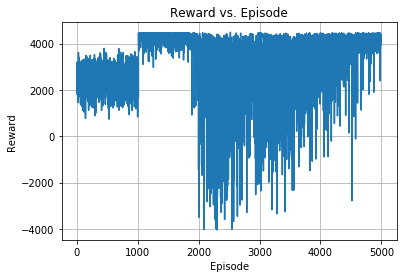

In [14]:
fig, ax = plt.subplots()
ax.plot(epi, Reward)

ax.set(xlabel='Episode', ylabel='Reward',
       title='Reward vs. Episode')
ax.grid()
plt.show()

In [15]:
RE

4487.209273247694

In [16]:
REX[-200:]

array([0.02999993, 0.45108911, 0.45108911, 0.45108911, 0.45108911,
       0.45108911, 0.45108911, 0.45108911, 0.45108911, 0.92158416,
       0.45108911, 0.45108911, 0.45108911, 0.45108911, 0.45108911,
       0.45108911, 0.45108911, 0.45108911, 0.45108911, 0.45108911,
       0.45108911, 0.45108911, 0.45108911, 0.45108911, 0.45108911,
       0.45108911, 0.45108911, 0.45108911, 0.45108911, 0.54019802,
       0.54019802, 0.54019802, 0.54019802, 0.54019802, 0.54019802,
       0.54019802, 0.54019802, 0.54019802, 0.54019802, 0.54019802,
       0.54019802, 0.54019802, 0.54019802, 0.54019802, 0.54019802,
       0.54019802, 0.54019802, 0.54019802, 0.54019802, 0.54019802,
       0.54019802, 0.54019802, 0.54019802, 0.54019802, 0.54019802,
       0.54019802, 0.54019802, 0.54019802, 0.54019802, 0.54019802,
       0.54019802, 0.54019802, 0.54019802, 0.54019802, 0.54019802,
       0.54019802, 0.54019802, 0.54019802, 0.54019802, 0.54019802,
       1.01148515, 0.54019802, 0.54019802, 0.54019802, 0.54019

In [17]:
fOBJ(REX[-200:],1,I,K,al,l,YGROSS,sigma,EIND,E,CCA,CCATOT,cumetree,MAT,MU,ML,FORC,TATM,TOCEAN,DAMFRAC,DAMAGES,ABATECOST,cost1,MCABATE,
         CPRICE,YNET,Y,C,CPC,PERIODU,CEMUTOTPER,RI,100)

4487.209273247694